# Prerequisites:
It is recommended to execute this notebook in a GPU environment. If you do not have access to one, consider running it on Kaggle kernels.

In [26]:
import os
import gc
import time
import torch
import random
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from pathlib import Path

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

import warnings
warnings.filterwarnings("ignore")

In [3]:
from transformers import AutoModel,AutoModelForMaskedLM,AutoTokenizer,AutoConfig
import transformers
print(transformers.__version__)

4.36.2


# Data

WDC LSPM

Many e-shops have started to mark-up product data within their HTML pages using the schema.org vocabulary. The Web Data Commons project regularly extracts such data from the Common Crawl, a large public web crawl. The Web Data Commons Training and Test Sets for Large-Scale Product Matching contain product offers from different e-shops in the form of binary product pairs (with corresponding label "match" or "no match") for four product categories, computers, cameras, watches and shoes.

In order to support the evaluation of machine learning-based matching methods, the data is split into training, validation and test sets. For each product category, we provide training sets in four different sizes (2.000-70.000 pairs). Furthermore there are sets of ids for each training set for a possible validation split (stratified random draw) available. The test set for each product category consists of 1.100 product pairs. The labels of the test sets were manually checked while those of the training sets were derived using shared product identifiers from the Web via weak supervision.

The data stems from the WDC Product Data Corpus for Large-Scale Product Matching - Version 2.0 which consists of 26 million product offers originating from 79 thousand websites.

http://webdatacommons.org/largescaleproductcorpus/wdc-products/

In [4]:
from datasets import load_dataset

In [5]:
data = load_dataset("wdc/products-2017")

In [6]:
data

DatasetDict({
    train: Dataset({
        features: ['pair_id', 'label', 'id_left', 'category_left', 'cluster_id_left', 'brand_left', 'title_left', 'description_left', 'price_left', 'specTableContent_left', 'id_right', 'category_right', 'cluster_id_right', 'brand_right', 'title_right', 'description_right', 'price_right', 'specTableContent_right'],
        num_rows: 6475
    })
    test: Dataset({
        features: ['pair_id', 'label', 'id_left', 'category_left', 'cluster_id_left', 'brand_left', 'title_left', 'description_left', 'price_left', 'specTableContent_left', 'id_right', 'category_right', 'cluster_id_right', 'brand_right', 'title_right', 'description_right', 'price_right', 'specTableContent_right'],
        num_rows: 1100
    })
    validation: Dataset({
        features: ['pair_id', 'label', 'id_left', 'category_left', 'cluster_id_left', 'brand_left', 'title_left', 'description_left', 'price_left', 'specTableContent_left', 'id_right', 'category_right', 'cluster_id_right', 'bra

In [7]:
df = pd.DataFrame(data['train'])
df.shape

(6475, 18)

In [8]:
df.head()

,pair_id,label,id_left,category_left,cluster_id_left,brand_left,title_left,description_left,price_left,specTableContent_left,id_right,category_right,cluster_id_right,brand_right,title_right,description_right,price_right,specTableContent_right
0,14219585#11723285,0,14219585,Computers_and_Accessories,521249,None,"""Apple - Mac Pro Desktop Computer 6-Core Inte...","""Apple Mac Pro MD878LL/A Desktop: Designed for...",None,None,11723285,Computers_and_Accessories,9835048,"""HP Enterprise""","""COMPAQ PL ML530R G3 Xeon 3.0GHz 1GB"", ""Null""...","""Description:\n271246-001 Proliant Xeon 3.0GH...",None,None
1,12092252#16476204,0,12092252,Computers_and_Accessories,222681,"""HP Enterprise""","""DG0300FARVV HP 300-GB 6G 10K 2.5 DP SAS"", ""N...","""Description:2 x 300GB 2.5-inch Serial Attache...",None,Specifications: Category Proliant HardDrive S...,16476204,Computers_and_Accessories,63553,"""HP Enterprise""","""DH0072BALWL HP 72-GB 3G 15K 2.5 DP SAS"" ""Null""","""Description:10 x 72GB 2.5-inch Serial Attach...","""CAD"", ""$757.74 CAD""",Specifications: Category Proliant HardDrive S...
2,10693245#16856034,1,10693245,Computers_and_Accessories,1404813,None,"""HP BL460c G7 Intel Xeon E5607 Processor Kit ...",None,None,Categorie Processors Merk HP Product HP BL460...,16856034,Computers_and_Accessories,1404813,"""HP Enterprise""","""637414-B21 HP Xeon E5607 2.26GHz BL460c G7 ""...","""Description:HP Intelï¿½ Xeonï¿½ E5607 BL460c ...",None,Specifications: Category Proliant Processor S...
3,2042153#7421086,0,2042153,Computers_and_Accessories,212917,"""MIO""","""MIO SD1GB-C230 BXP 1GB 9p SD Secure Digital ...","""SD1GB-C230 BXP 1GB 9p SD Secure Digital Card...","""USD"", ""4.85""",None,7421086,Computers_and_Accessories,1441832,"""HP""","""HP 358348-B21 ADJ 1GB 184p PC2700 CL2.5 18c ...","""358348-B21 ADJ 1GB 184p PC2700 CL2.5 18c 128...","""USD"", ""13.98""",None
4,11210178#16709272,1,11210178,Computers_and_Accessories,150997,"""MSI""","""MSI - GeForce GTX 1080 8GB GAMING X 8G Video...",None,None,None,16709272,Computers_and_Accessories,150997,None,"""nVidia GTX 1080 Gaming X 8Go""","""MSI GeForce GTX 1080 Gaming X 8G, Actif, ATX,...",None,None


In [9]:
df[df.label==1].iloc[1]

pair_id                                                   11210178#16709272
label                                                                     1
id_left                                                            11210178
category_left                                     Computers_and_Accessories
cluster_id_left                                                      150997
brand_left                                                            "MSI"
title_left                 "MSI - GeForce GTX 1080 8GB GAMING X 8G Video...
description_left                                                       None
price_left                                                             None
specTableContent_left                                                  None
id_right                                                           16709272
category_right                                    Computers_and_Accessories
cluster_id_right                                                     150997
brand_right 

#### Assess the quality of the labels
- Check some exemples and evaluate the quality of the labels

# Dataset

In [10]:
# Create your Dataset class

In [11]:
# Import necessary modules
from torch.utils.data import Dataset, DataLoader

## =============================================================================== ##
# Define a custom dataset class for retrieval tasks
class RetrievalDataset(Dataset):
    def __init__(self,
                 df,
                 tokenizer,
                 description_name,
                 max_length=512,
                ):
        # Initialize the dataset with necessary parameters
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.description_name = description_name
        
        # Prepare the dataframe by handling missing values and sorting by description length
        self.df = self.prepare_df(df)

    def prepare_df(self, df):
        # Convert description column to string, handle missing values, and add a length column
        df[self.description_name] = df[self.description_name].astype(str).fillna('')
        df[f"{self.description_name}_len"] = df[self.description_name].astype(str).apply(len)
        # Sort the dataframe based on description length
        df = df.sort_values(f"{self.description_name}_len").reset_index(drop=True)
        return df

    def make_one_item(self, idx):
        # Tokenize the description at the specified index using the provided tokenizer
        encoding = self.tokenizer(
            self.df.iloc[idx][self.description_name],
            truncation=True if self.max_length else False,
            max_length=self.max_length,
            add_special_tokens=True,
            return_offsets_mapping=False,
        )
        
        # Return the tokenized output as a dictionary
        outputs = dict(**encoding)
        return outputs
    
    def __len__(self) -> int:
        # Return the length of the dataset
        return len(self.df)
    
    def __getitem__(self, idx):
        # Get a single item from the dataset at the specified index
        return self.make_one_item(idx)


## =============================================================================== ##
## =============================================================================== ##
# Define a custom collator class for DataLoader
class CustomCollator():
    def __init__(self, tokenizer):
        # Initialize the collator with the provided tokenizer
        self.tokenizer = tokenizer

    def __call__(self, batch):
        # Collate a batch of samples

        # Initialize the output dictionary
        output = dict()

        # Extract input_ids and attention_mask from each sample in the batch
        output["input_ids"] = [sample["input_ids"] for sample in batch]
        output["attention_mask"] = [sample["attention_mask"] for sample in batch]

        # Find the maximum length in the batch
        batch_max = max([len(ids) for ids in output["input_ids"]])

        # Add padding to the sequences based on the tokenizer's padding side
        if self.tokenizer.padding_side == "right":
            output["input_ids"] = [s + (batch_max - len(s)) * [self.tokenizer.pad_token_id] for s in output["input_ids"]]
            output["attention_mask"] = [s + (batch_max - len(s)) * [0] for s in output["attention_mask"]]
        else:
            output["input_ids"] = [(batch_max - len(s)) * [self.tokenizer.pad_token_id] + s for s in output["input_ids"]]
            output["attention_mask"] = [(batch_max - len(s)) * [0] + s for s in output["attention_mask"]]

        # Convert the padded sequences to PyTorch tensors
        output["input_ids"] = torch.tensor(output["input_ids"], dtype=torch.long)
        output["attention_mask"] = torch.tensor(output["attention_mask"], dtype=torch.long)

        # Return the collated batch as a dictionary of tensors
        return output


In [12]:
model_name = "sentence-transformers/all-MiniLM-L6-v2"
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [13]:
ds = RetrievalDataset(df,tokenizer,description_name="title_left",max_length=512)

In [14]:
ds[0]

{'input_ids': [101, 1000, 6522, 21103, 4583, 12740, 1000, 102],
 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0],
 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1]}

In [15]:
ds.df.iloc[0]['title_left']

' "HP Envy 5540"'

In [16]:
tokenizer.convert_ids_to_tokens(ds[0]['input_ids'])

['[CLS]', '"', 'hp', 'envy', '55', '##40', '"', '[SEP]']

# Data Loaders

In [17]:
def batch_to_device(batch, device):
    batch_dict = {key: batch[key].to(device) for key in batch}
    return batch_dict

# Models

### Pooling Strategie

In [18]:
# Import necessary PyTorch modules
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter

# Define a MeanPooling module for computing mean embeddings
class MeanPooling(nn.Module):
    def __init__(self):
        super(MeanPooling, self).__init__()

    def forward(self, last_hidden_state, attention_mask):
        # Apply mean pooling to the last hidden state using attention mask
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size())
        sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)
        sum_mask = input_mask_expanded.sum(1)
        sum_mask = torch.clamp(sum_mask, min=1e-9)
        mean_embeddings = sum_embeddings / sum_mask
        return mean_embeddings

# Define a MaxPooling module for computing max embeddings
class MaxPooling(nn.Module):
    def __init__(self):
        super(MaxPooling, self).__init__()

    def forward(self, last_hidden_state, attention_mask):
        # Apply max pooling to the last hidden state using attention mask
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size())
        embeddings = last_hidden_state.clone()
        embeddings[input_mask_expanded == 0] = -1e4
        max_embeddings, _ = torch.max(embeddings, dim=1)
        return max_embeddings

# Define a MinPooling module for computing min embeddings
class MinPooling(nn.Module):
    def __init__(self):
        super(MinPooling, self).__init__()

    def forward(self, last_hidden_state, attention_mask):
        # Apply min pooling to the last hidden state using attention mask
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size())
        embeddings = last_hidden_state.clone()
        embeddings[input_mask_expanded == 0] = 1e4
        min_embeddings, _ = torch.min(embeddings, dim=1)
        return min_embeddings

# Define a general NLP Pooling module that can switch between different pooling strategies
class NLPPooling(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        # Update module attributes with provided keyword arguments
        self.__dict__.update(kwargs)
        # Initialize the specified pooling module based on the pooling_name
        if self.pooling_name not in ("CLS", ''):
            self.pooler = eval(self.pooling_name)()

        # Print the chosen pooling strategy
        print(f'Pooling: {self.pooling_name}')

    def forward(self, last_hidden_state, attention_mask):
        # Apply the specified pooling strategy to the last hidden state based on pooling_name

        if self.pooling_name in ['MeanPooling', 'MaxPooling', 'MinPooling']:
            # Pooling between cls and sep / cls and sep embeddings are not included
            last_hidden_state = self.pooler(last_hidden_state, attention_mask)
        elif self.pooling_name == "CLS":
            # Use only cls embedding
            last_hidden_state = last_hidden_state[:, 0, :]
        else:
            # No pooling
            last_hidden_state = last_hidden_state
            # print(f"{self.pooling_name} not implemented")
        return last_hidden_state


### Model class

In [25]:
# Import necessary PyTorch modules and utility functions


# Define a RetrievalModel class as a PyTorch module
class RetrievalModel(nn.Module):
    def __init__(self, model_name, pooling_params={}):
        # Initialize the RetrievalModel with specified model_name and pooling parameters
        super().__init__()

        # Load model configuration with hidden states and the backbone model
        self.model_name = model_name
        self.config = AutoConfig.from_pretrained(model_name, output_hidden_states=True)
        self.backbone = AutoModel.from_pretrained(model_name)

        # Update pooling_params with default in_features and out_features values
        self.pooling_params = pooling_params
        self.pooling_params.update({
            "in_features": self.config.hidden_size,
            "out_features": self.config.hidden_size
        })

        # Initialize NLPPooling layer with updated pooling_params
        self.pool_ly = NLPPooling(**self.pooling_params)

    def forward(self, b):
        # Forward pass through the model's backbone and apply pooling on the last hidden layers
        x = self.backbone(input_ids=b["input_ids"], attention_mask=b["attention_mask"]).last_hidden_state
        x = self.pool_ly(x, b['attention_mask'])

        # Normalize the embedding vector
        x = torch.nn.functional.normalize(x, p=2, dim=1)
        return x


# ----------------------------------------------------------------------------- #
# Define a function to get embeddings using the RetrievalModel
def get_embeddings(df, description_name, model_name, pooling_params):
    # Initialize the RetrievalModel with specified model_name and pooling_params
    model = RetrievalModel(model_name, pooling_params)

    # Load the tokenizer corresponding to the model
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    # Create a RetrievalDataset using the provided dataframe, tokenizer, and description_name
    ds = RetrievalDataset(df, tokenizer, description_name, max_length=512)

    # Create a DataLoader for batching and collating data
    data_collator = CustomCollator(tokenizer)
    data_loader = DataLoader(ds, batch_size=32, drop_last=False, num_workers=0, pin_memory=False, shuffle=False,
                              collate_fn=data_collator)

    # Determine the device (cuda or cpu) for training
    device = torch.device(f"cuda" if torch.cuda.is_available() else "cpu")
    print(f"device :{device}")

    # Move the model to the specified device and set it to evaluation mode
    model = model.to(device)
    model.eval()

    # Create an empty list to store computed embeddings
    y_embed = []

    # Use torch.no_grad() to avoid unnecessary computations for gradients
    with torch.no_grad():
        # Iterate through the DataLoader and compute embeddings batch-wise
        for data in tqdm(data_loader):
            data = batch_to_device(data, device)
            pred = model(data)
            y_embed.append(pred)

    # Concatenate the computed embeddings and move them to the cpu
    y_embed = torch.cat(y_embed, dim=0).detach().cpu()

    # Return the dataframe and computed embeddings
    return ds.df, y_embed

In [21]:
pooling_params = {"pooling_name":"MeanPooling","params":{}}
model_name = "sentence-transformers/all-MiniLM-L6-v2"

In [22]:
description_name = "title_left"
df,query_embed = get_embeddings(df,description_name,model_name,pooling_params)
query_embed.shape

Pooling: MeanPooling
device :cuda


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203/203 [00:03<00:00, 62.88it/s]


torch.Size([6475, 384])

In [27]:
query_embed.shape

torch.Size([6475, 384])

In [28]:
df.title_left.values[1]

' "Asus H81-Plus"'

In [29]:
df.title_right.values[1]

' "ASUS H81-PLUS" "Asus catálogo - Powerplanetonline"'

In [30]:
description_name = "title_right"
db_df,db_embed = get_embeddings(df.copy(),description_name,model_name,pooling_params)
db_embed.shape

Pooling: MeanPooling
device :cuda


  0%|          | 0/203 [00:00<?, ?it/s]

torch.Size([6475, 384])

In [31]:
# Compute cosine similarity
def get_sim(a,b):
    s = torch.mm(a,b.transpose(0, 1))
    return s

In [32]:
sim_score = get_sim(query_embed,db_embed)
sim_score.shape

torch.Size([6475, 6475])

In [33]:
sim_score_idx  = torch.argsort(sim_score,descending=True)
sim_score_idx.shape

torch.Size([6475, 6475])

In [34]:
## Get candidates index 
TOPK  = 10
query_desc = df["title_left"].values
db_desc = db_df['title_right'].values

df_res = []
for i,desc in tqdm(enumerate(query_desc)):

    idx = sim_score_idx[i,:TOPK]
    s = sim_score[i,idx]
    df_res.append(pd.DataFrame({"title_left":[query_desc[i]]*TOPK,
                                'title_right_pred':db_desc[idx.numpy()],
                                'score':s}))

0it [00:00, ?it/s]

In [35]:
df_res = pd.concat(df_res)
df_res.shape

(64750, 3)

In [36]:
df_res.head()

,title_left,title_right_pred,score
0,"""HP Envy 5540""","""HP ENVY x360 - 15-bp010ca""@en",0.7794
1,"""HP Envy 5540""","""HP ENVY x360 - 15-bp010ca""@en",0.7794
2,"""HP Envy 5540""","""HP ENVY x360 15-bp100na Convertible Laptop""@en",0.7167
3,"""HP Envy 5540""","""HP ENVY x360 15-bp100na Convertible Laptop""@en",0.7167
4,"""HP Envy 5540""","""HP ENVY x360 15-bp100na Convertible Laptop""@en",0.7167


In [37]:
df_res_grouped = df_res.groupby('title_left').agg(list).reset_index()

In [38]:
df_res_grouped.head()

,title_left,title_right_pred,score
0,""" AMD Black Edition A8 5600K / 3.6 GHz proces...","[ "" AMD Black Edition A8 5600K / 3.6 GHz proce...","[1.000000238418579, 1.000000238418579, 0.79045..."
1,""" ASUS HD7850-DC2-2GD5-V2 graphics card - Rad...","[ ""Asus - Radeon HD 7850 2GB Video Card"" Card ...","[0.8038597106933594, 0.7793077230453491, 0.779..."
2,""" AUGUSTUS Deckenleuchte Chrom, 1xLED - Leuch...","[ "" AUGUSTUS Deckenleuchte Chrom, 1xLED - Leuc...","[0.9999998807907104, 0.9999998807907104, 0.999..."
3,""" Adaptateur..."", Câble audio..."", ""Adaptateu...","[ ""StarTech.com DisplayPort to HDMI Video Conv...","[0.5635592937469482, 0.5554509162902832, 0.549..."
4,""" Alfa AWUS036H 1000mW 1W Deluxe Bundle 802.1...","[ ""Alfa AWUS036H 1000mW 1W Deluxe Bundle 802.1...","[0.9626172184944153, 0.933559000492096, 0.4446..."


In [39]:
df_gt = df[df.label==1].groupby('title_left').agg({"title_right":list}).reset_index()
df_gt.head()

,title_left,title_right
0,""" AUGUSTUS Deckenleuchte Chrom, 1xLED - Leuch...","[ ""Scratch & Dent Acer Chromebook C731T-C42N C..."
1,""" Adaptateur..."", Câble audio..."", ""Adaptateu...","[ ""StarTech.com DisplayPort to HDMI Video Adap..."
2,""" Alfa AWUS036H 1000mW 1W Deluxe Bundle 802.1...","[ ""Alfa AWUS036H 1000mW 1W Deluxe Bundle 802.1..."
3,""" Apple 12.9-inch iPad Pro Wi-Fi 256GB - Spac...","[ ""Apple iPad Pro 12.9"" Retina Display 256GB W..."
4,""" Apple Mac Pro MD878LL/A Desktop Computer; I...","[ ""Mac Pro Xeon E5 3.5GHz (256GB)""]"


In [40]:
df_gt.iloc[10]['title_left']

' " Dell Inspiron 710M PA-10 Power Adapter (PA-1900-02D) - MachinaElectronics.com'

In [41]:
df_gt.iloc[10]['title_right']

[' " Dell Precision M60 PA-10 Power Adapter (PA-1900-02D) - MachinaElectronics.com']

In [42]:
df_eval = df_gt.merge(df_res_grouped,how='left',on="title_left")
df_eval.head()

,title_left,title_right,title_right_pred,score
0,""" AUGUSTUS Deckenleuchte Chrom, 1xLED - Leuch...","[ ""Scratch & Dent Acer Chromebook C731T-C42N C...","[ "" AUGUSTUS Deckenleuchte Chrom, 1xLED - Leuc...","[0.9999998807907104, 0.9999998807907104, 0.999..."
1,""" Adaptateur..."", Câble audio..."", ""Adaptateu...","[ ""StarTech.com DisplayPort to HDMI Video Adap...","[ ""StarTech.com DisplayPort to HDMI Video Conv...","[0.5635592937469482, 0.5554509162902832, 0.549..."
2,""" Alfa AWUS036H 1000mW 1W Deluxe Bundle 802.1...","[ ""Alfa AWUS036H 1000mW 1W Deluxe Bundle 802.1...","[ ""Alfa AWUS036H 1000mW 1W Deluxe Bundle 802.1...","[0.9626172184944153, 0.933559000492096, 0.4446..."
3,""" Apple 12.9-inch iPad Pro Wi-Fi 256GB - Spac...","[ ""Apple iPad Pro 12.9"" Retina Display 256GB W...","[ "" Apple 12.9-inch iPad Pro Wi-Fi 256GB - Spa...","[0.9999995827674866, 0.9662576913833618, 0.966..."
4,""" Apple Mac Pro MD878LL/A Desktop Computer; I...","[ ""Mac Pro Xeon E5 3.5GHz (256GB)""]","[ ""Apple MacBook Pro - 13.3"" Core i5 4 GB RAM ...","[0.7711371183395386, 0.7711371183395386, 0.771..."


In [43]:
df_eval['title_right'].apply(len).value_counts()

1    1065
2     150
3      15
Name: title_right, dtype: int64

In [45]:
df_eval.iloc[10]['title_left']

' " Dell Inspiron 710M PA-10 Power Adapter (PA-1900-02D) - MachinaElectronics.com'

In [46]:
df_eval.iloc[10]['title_right']

[' " Dell Precision M60 PA-10 Power Adapter (PA-1900-02D) - MachinaElectronics.com']

In [47]:
df_eval.iloc[10]['title_right_pred']

[' " Dell Inspiron N4020 PA-10 Power Adapter (PA-1900-02D) - MachinaElectronics.com',
 ' " Dell Inspiron 1521 PA-10 Power Adapter (PA-1900-02D) - MachinaElectronics.com',
 ' " Dell Precision M60 PA-10 Power Adapter (PA-1900-02D) - MachinaElectronics.com',
 ' "Hewlett Packard Enterprise 64-bit/66-MHz Single Channel Wide Ultra3 SCSI Adapter power adapter & inverter" "Product data Hewlett inverter adapters inverters (154457-B21)"',
 ' "Hewlett Packard Enterprise 64-bit/66-MHz Single Channel Wide Ultra3 SCSI Adapter power adapter & inverter" "Product data Hewlett inverter adapters inverters (154457-B21)"',
 ' "629142-B21 HP FlexFabric 10Gb 2-Port 554FLR Adapter", "Null" Price 629142-B21" "New 629142-B21 Adapter Wholesale',
 ' "629142-B21 HP FlexFabric 10Gb 2-Port 554FLR Adapter", "Null" Price 629142-B21" "New 629142-B21 Adapter Wholesale',
 ' "629142-B21 HP FlexFabric 10Gb 2-Port 554FLR Adapter", "Null" Price 629142-B21" "New 629142-B21 Adapter Wholesale',
 ' "629142-B21 HP FlexFabric 10Gb

# Evaluation

In [48]:
def getMetric(col1,col):
    def score(row):
        n = len(np.intersect1d(row[col1],row[col]) )
        return 1 if n>0 else 0
    return score

In [49]:
df_eval['score_row'] = df_eval.apply(getMetric('title_right','title_right_pred'),axis=1)

In [50]:
df_eval.sample(100)

,title_left,title_right,title_right_pred,score,score_row
344,"""Acer KA KA240H 24"" Full HD TN Negro pantalla...","[ ""Acer KA240H 24""@en 24inch LED Monitor - 16:...","[ ""Acer KA KA240H 24"" Full HD TN Negro pantall...","[1.0, 0.7894200682640076, 0.7894200682640076, ...",0
721,"""Gigaram TS128GCF1000 DFG 128GB 50p CF 1000x ...","[ ""SanDisk SDCFXPS-128G DFC 128GB 50p CF 1066x...","[ ""Gigaram TS32GCF1000 DFE 32GB 50p CF 1000x 1...","[0.9548277854919434, 0.8072405457496643, 0.795...",1
414,"""Apple Smart Keyboard for 9.7-inch iPad Pro M...","[ ""Smart Keyboard APPLE para iPad Pro 9.7”""@es]","[ ""Apple Smart Keyboard for 9.7-inch iPad Pro ...","[1.0000003576278687, 0.8883680701255798, 0.888...",0
1051,"""Samsung - 840 EVO 250GB 2.5"" Solid State Dri...","[ ""Samsung 840 Evo (250GB)""@en Prices - CNET""@en]","[ ""Samsung - 840 EVO 250GB 2.5"" Solid State Dr...","[0.9999998211860657, 0.9999998211860657, 0.938...",0
613,"""Corsair XMS3 8GB (2x4GB) DDR3 PC3-12800 1600...","[ ""Corsair XMS3 8GB (2x4GB) DDR3 PC3-12800C9 1...","[ ""Corsair XMS3 8GB (2x4GB) DDR3 PC3-12800 160...","[0.9999995827674866, 0.9999995827674866, 0.955...",1
92,"""323146-B21 BL20p Xeon 3.06GHz"" ""Null""","[ ""323146-B21 BL20P G2 (1P) Xeon 3.06GHz"", ""Nu...","[ ""323146-B21 BL20p Xeon 3.06GHz"" ""Null"", ""32...","[0.9999998211860657, 0.9999998211860657, 0.902...",0
1170,"""Tp-Link TL-SF1008D 8 Portlu 10/100 Ethernet ...","[ ""TPLINK - SWITCH 8 PUERTOS MINI 10/100""@es ""...","[ ""TP-Link TL-SF1008D-8-Port 10/100Mbps Deskto...","[0.7975758910179138, 0.7568085789680481, 0.748...",1
517,"""Corsair - Air Series SP120 High Performance ...","[ ""Corsair Air Series SP120 High Performance E...","[ ""Corsair - Air Series SP120 High Performance...","[1.0000004768371582, 0.8943998217582703, 0.894...",0
704,"""Gigabyte GeForce GTX 1060 G1 Gaming 3072MB G...","[ ""Gigabyte GeForce GTX 1060 G1 Gaming 3G - Pr...","[ ""Gigabyte GeForce GTX 1060 G1 Gaming 3072MB ...","[1.0000004768371582, 1.0000004768371582, 1.000...",0
83,"""3.5 pouces Red 2To IntelliPower 64Mo Sata 6G...","[ ""WD Red 2TB WD20EFRX""@es]","[ ""3.5 pouces - WD RED NAS 6To 5400T/min 64Mo ...","[0.8323203325271606, 0.823881983757019, 0.8209...",0


<Axes: >

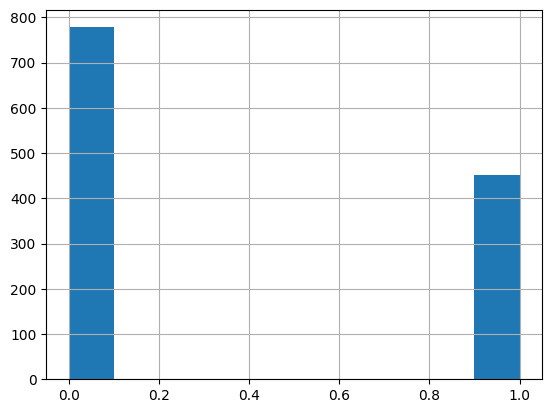

In [51]:
df_eval['score_row'].hist()

In [52]:
df_eval['score_row'].mean()

0.367479674796748

# Retrieval:  Using Faiss and BAAI/bge-large-en-v1.5

In [53]:
pooling_params = {"pooling_name":"MeanPooling","params":{}}
model_name = "BAAI/bge-large-en-v1.5"

In [54]:
description_name = "title_left"
df,query_embed = get_embeddings(df,description_name,model_name,pooling_params)
query_embed.shape

Pooling: MeanPooling
device :cuda


  0%|          | 0/203 [00:00<?, ?it/s]

torch.Size([6475, 1024])

In [55]:
description_name = "title_right"
db_df,db_embed = get_embeddings(df.copy(),description_name,model_name,pooling_params)
db_embed.shape

Pooling: MeanPooling
device :cuda


  0%|          | 0/203 [00:00<?, ?it/s]

torch.Size([6475, 1024])

### Similarty search with faiss

In [ ]:
!pip install faiss-gpu # remplace gpu by cpu if your machine have no gpu

### Faiss git repo and documentation
    - https://github.com/facebookresearch/faiss
    - https://faiss.ai/index.html 

In [56]:
import faiss
# ======================================================================================= #
def create_faiss_embedd(db_embed,path_to_save=None):
    vector_dimension = db_embed.shape[1]
    
    index = faiss.IndexFlatIP(vector_dimension)
    index.add(db_embed)
    if path_to_save:
        faiss.write_index(index,path_to_save)
    return index

# ======================================================================================= #
def search_from_faiss_index(query_embed,query_df,query_desc,db_df,features_database,faiss_index,top_k=3):
    
    distances,neighbours = faiss_index.search(query_embed,k=top_k)
    
    if distances.shape[0]:
        df_result = []
        for i in tqdm(range(distances.shape[0])):
            d,idx = distances[i],neighbours[i]
            dx = db_df.iloc[idx][features_database]
            dx['score'] = d
            dx['query_desc'] = query_df[query_desc].values[i]
            dx = dx[["query_desc",'score']+features_database]
            df_result.append(dx)
            
        df_result = pd.concat(df_result,axis=0).reset_index(drop=True)
    else:
        df_result = pd.DataFrame()
    
    return df_result     

In [57]:
faiss_index = create_faiss_embedd(db_embed.numpy(),path_to_save=None)

In [58]:
query_desc = "title_left"
features_database = ['title_right']

df_result = search_from_faiss_index(query_embed.numpy(),df,query_desc,
                                    db_df,features_database,faiss_index,top_k=TOPK)

  0%|          | 0/6475 [00:00<?, ?it/s]

In [59]:
df_result.head()

,query_desc,score,title_right
0,"""HP Envy 5540""",0.8692,"""HP ENVY 5540 All-in-One Printer""@en"
1,"""HP Envy 5540""",0.8321,"""HP ENVY Impresora 5540 All-in-One""@es Tu tie..."
2,"""HP Envy 5540""",0.8170,"""HP ENVY x360 - 15-bp010ca""@en"
3,"""HP Envy 5540""",0.8170,"""HP ENVY x360 - 15-bp010ca""@en"
4,"""HP Envy 5540""",0.8067,"""Imprimante tout-en-un HP ENVY Photo 7130""@fr"


In [60]:
df_result_grouped = df_result.groupby('query_desc').agg(list).reset_index()
df_result_grouped.head()

,query_desc,score,title_right
0,""" AMD Black Edition A8 5600K / 3.6 GHz proces...","[0.9999999403953552, 0.9999999403953552, 0.861...","[ "" AMD Black Edition A8 5600K / 3.6 GHz proce..."
1,""" ASUS HD7850-DC2-2GD5-V2 graphics card - Rad...","[0.928277313709259, 0.8757278919219971, 0.8567...","[ ""Asus - Radeon HD 7850 2GB Video Card"" Card ..."
2,""" AUGUSTUS Deckenleuchte Chrom, 1xLED - Leuch...","[0.9999999403953552, 0.9999999403953552, 0.999...","[ "" AUGUSTUS Deckenleuchte Chrom, 1xLED - Leuc..."
3,""" Adaptateur..."", Câble audio..."", ""Adaptateu...","[0.796923041343689, 0.796923041343689, 0.78933...","[ ""ADAPTADOR USB3.0 A VGA CABLE"" CABLE | Tradi..."
4,""" Alfa AWUS036H 1000mW 1W Deluxe Bundle 802.1...","[0.9778767228126526, 0.9760943651199341, 0.751...","[ ""Alfa AWUS036H 1000mW 1W Deluxe Bundle 802.1..."


In [68]:
df_eval2 = df_result_grouped.merge(df_gt,how='right',left_on="query_desc",right_on="title_left",suffixes=('_pred',""))
df_eval2.head()

,query_desc,score,title_right_pred,title_left,title_right
0,""" AUGUSTUS Deckenleuchte Chrom, 1xLED - Leuch...","[0.9999999403953552, 0.9999999403953552, 0.999...","[ "" AUGUSTUS Deckenleuchte Chrom, 1xLED - Leuc...",""" AUGUSTUS Deckenleuchte Chrom, 1xLED - Leuch...","[ ""Scratch & Dent Acer Chromebook C731T-C42N C..."
1,""" Adaptateur..."", Câble audio..."", ""Adaptateu...","[0.796923041343689, 0.796923041343689, 0.78933...","[ ""ADAPTADOR USB3.0 A VGA CABLE"" CABLE | Tradi...",""" Adaptateur..."", Câble audio..."", ""Adaptateu...","[ ""StarTech.com DisplayPort to HDMI Video Adap..."
2,""" Alfa AWUS036H 1000mW 1W Deluxe Bundle 802.1...","[0.9778767228126526, 0.9760943651199341, 0.751...","[ ""Alfa AWUS036H 1000mW 1W Deluxe Bundle 802.1...",""" Alfa AWUS036H 1000mW 1W Deluxe Bundle 802.1...","[ ""Alfa AWUS036H 1000mW 1W Deluxe Bundle 802.1..."
3,""" Apple 12.9-inch iPad Pro Wi-Fi 256GB - Spac...","[1.0, 0.9632233381271362, 0.9632233381271362, ...","[ "" Apple 12.9-inch iPad Pro Wi-Fi 256GB - Spa...",""" Apple 12.9-inch iPad Pro Wi-Fi 256GB - Spac...","[ ""Apple iPad Pro 12.9"" Retina Display 256GB W..."
4,""" Apple Mac Pro MD878LL/A Desktop Computer; I...","[0.8839761018753052, 0.8839761018753052, 0.824...","[ ""Mac Pro Xeon E5 3.5GHz (256GB)"", ""Mac Pro ...",""" Apple Mac Pro MD878LL/A Desktop Computer; I...","[ ""Mac Pro Xeon E5 3.5GHz (256GB)""]"


In [69]:
df[df.title_left==' " Apple Smart Cover for 10.5-inch iPad Pro - Midnight Blue MQ092ZM/A "@us']

,pair_id,label,id_left,category_left,cluster_id_left,brand_left,title_left,description_left,price_left,specTableContent_left,id_right,category_right,cluster_id_right,brand_right,title_right,description_right,price_right,specTableContent_right,title_left_len
2172,10111579#7937053,0,10111579,Computers_and_Accessories,1295417,"""Apple""@us",""" Apple Smart Cover for 10.5-inch iPad Pro - ...","""Smart Cover for 10.5-inch iPad Pro - Midnigh...","""49.00""@us, ""USD""@us",None,7937053,Computers_and_Accessories,196870,None,"""Apple Smart Cover iPad Pro 2017 10.5 Roze - ...",None,None,Categorie Tablet-accessoires Merk Apple Produ...,74


In [70]:
df_eval2.iloc[10]['query_desc']

' " Dell Inspiron 710M PA-10 Power Adapter (PA-1900-02D) - MachinaElectronics.com'

In [71]:
df_eval2.iloc[10]['title_right']

[' " Dell Precision M60 PA-10 Power Adapter (PA-1900-02D) - MachinaElectronics.com']

In [72]:
df_eval2.iloc[10]['title_right_pred']

[' " Dell Inspiron 1521 PA-10 Power Adapter (PA-1900-02D) - MachinaElectronics.com',
 ' " Dell Inspiron N4020 PA-10 Power Adapter (PA-1900-02D) - MachinaElectronics.com',
 ' " Dell Precision M60 PA-10 Power Adapter (PA-1900-02D) - MachinaElectronics.com',
 ' "629142-B21 HP FlexFabric 10Gb 2-Port 554FLR Adapter" "Null"',
 ' "629142-B21 HP FlexFabric 10Gb 2-Port 554FLR Adapter" "Null"',
 ' "629142-B21 HP FlexFabric 10Gb 2-Port 554FLR Adapter" "Null"',
 ' "629142-B21 HP FlexFabric 10Gb 2-Port 554FLR Adapter" "Null"',
 ' "629142-B21 HP FlexFabric 10Gb 2-Port 554FLR Adapter" "Null"',
 ' "629142-B21 HP FlexFabric 10Gb 2-Port 554FLR Adapter", "Null" Price 629142-B21" "New 629142-B21 Adapter Wholesale',
 ' "629142-B21 HP FlexFabric 10Gb 2-Port 554FLR Adapter", "Null" Price 629142-B21" "New 629142-B21 Adapter Wholesale']

In [73]:
df_eval2['score_row'] = df_eval2.apply(getMetric('title_right','title_right_pred'),axis=1)

<Axes: >

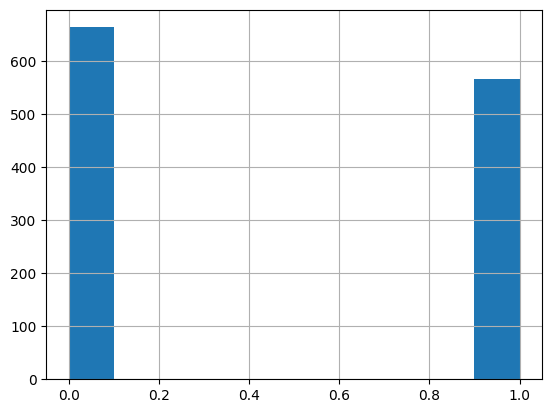

In [74]:
df_eval2['score_row'].hist()

In [75]:
df_eval2['score_row'].mean()

0.46016260162601624

In [76]:
df_eval['score_row'].mean()

0.367479674796748

# MTEB GITHUB 
https://github.com/embeddings-benchmark/mteb#leaderboard

# MTEB HUGGING FACE
https://huggingface.co/spaces/mteb/leaderboard

# Exercise 1: RAG application
1. Add more context (such as product category_left, description, brand etc.. ) to title_left and title_right before searching
2. Search for relevante products
3. Evaluate your RAG model


# Exercise 2: Implement SFR-Embedding-Mistral for Information Retrieval

https://huggingface.co/Salesforce/SFR-Embedding-Mistral

In [ ]:
# Your code


In [ ]:
# Your code


In [ ]:
# Your code


In [ ]:
# Your Evaluation


In [ ]:
# Compare your result with result from "sentence-transformers/all-MiniLM-L6-v2"
